## Congruencial

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import math

def  congruencial(x0):
    a = 1664525
    b = 1013904223
    m = 2**32
    xi = x0
    ui =0
    xi = (a*xi + b)%(m)
    ui = float(xi)/float(m)

    return ui,xi

## Exponencial

In [2]:
def expon(landa,x0):
    ui,x0 = congruencial(x0)   
    exp = (-math.log(1-ui))/landa   
    return exp,x0 

## Uniforme

In [3]:
def uniforme(a,b,x0):
    ui,x0 = congruencial(x0)
    uni = a + ui*(b-a)     
    return uni,x0

Bank renege
 0.0000 Customer00: Here I am
 0.0000 Customer00: Waited  0.000
 1.4541 Customer01: Here I am
 1.9153 Customer02: Here I am
 3.4541 Customer01: RENEGED after  2.000
 3.7806 Customer00: Finished
 3.7806 Customer02: Waited  1.865
 4.9799 Customer02: Finished
 6.2206 Customer03: Here I am
 6.2206 Customer03: Waited  0.000
 7.4793 Customer04: Here I am
 9.4793 Customer04: RENEGED after  2.000
17.4142 Customer03: Finished
Numero De clientes= 5
Numero De  Clientes Atendidos= 3
Numero De Clientes que Abandonaron= 2
Personas en la fila=
[1, 0, 1, 2, 1, 0, 1, 0, 1, 0]
Clientes en el banco=
[1, 2, 3, 2, 1, 0, 1, 2, 1, 0]
Promedio de personas en fila=
1.0


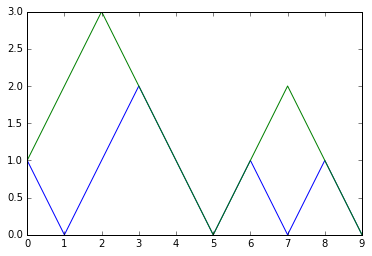

In [12]:
import random
import simpy

RANDOM_SEED = 42
x0uniform =RANDOM_SEED
x0expon  = RANDOM_SEED

NEW_CUSTOMERS = 5
INTERVAL_CUSTOMERS =5 
MIN_PATIENCE = 2
MAX_PATIENCE = 4
time_in_bank = 13

numCli = 0
numCliAtendidos = 0
numCliAbandonaron = 0
tiempoPromedioEspera = 0
tamfila = 0
tamPromedioFila = []
tiempo = []
cliBanc = 0
clientesEnBanco = []

def source(env, number, interval, counter):
    """Source generates customers randomly"""
    x0 = RANDOM_SEED
    global time_in_bank
    
    for i in range(number):
        c = customer(env,'Customer%02d' % i, counter, time_in_bank)
        env.process(c)
        exp,x0 = expon((1.0/interval),x0)
        t = exp
        yield env.timeout(t)
    
def promedio(listas):
    sum=0.0
    
    for i in range(0,len(listas)):
        sum=sum+listas[i]
        
    return sum/len(listas)    

def customer(env, name, counter, time_in_bank):
    #x0uniform = RANDOM_SEED
    global x0expon
    global x0uniform
    global numCli 
    global numCliAtendidos
    global numCliAbandonaron
    global tamfila
    global tamPromedioFila
    global tiempo
    global cliBanc
    global clientesEnBanco
    """Customer arrives, is served and leaves."""
    arrive = env.now
    print('%7.4f %s: Here I am' % (arrive, name))
    
    numCli +=1
    cliBanc +=1
    clientesEnBanco.append(cliBanc)
    #tiempo.append(arrive)
    tamfila+=1
    tamPromedioFila.append(tamfila)
    with counter.request() as req:
        patience,x0uniform = uniforme(MIN_PATIENCE,MIN_PATIENCE,x0uniform)
        # Wait for the counter or abort at the end of our tether
        results = yield req | env.timeout(patience)

        wait = env.now - arrive

        if req in results:
            # We got to the counter
            print('%7.4f %s: Waited %6.3f' % (env.now, name, wait))
            tamfila-=1
            tamPromedioFila.append(tamfila)
           
            exp,x0expon = expon((1.0/time_in_bank),x0expon)
            tib = exp            
            yield env.timeout(tib)    
            
            print('%7.4f %s: Finished' % (env.now, name))
           
            
            numCliAtendidos += 1
        else:
            # We reneged
            print('%7.4f %s: RENEGED after %6.3f' % (env.now, name, wait))
            numCliAbandonaron += 1
            tamfila-=1
            tamPromedioFila.append(tamfila)
        cliBanc -=1
        clientesEnBanco.append(cliBanc)
        #tiempo.append(arrive)

            
            
# Setup and start the simulation
print('Bank renege')
random.seed(RANDOM_SEED)
env = simpy.Environment()

# Start processes and run
counter = simpy.Resource(env, capacity=1)
env.process(source(env, NEW_CUSTOMERS, INTERVAL_CUSTOMERS, counter))
env.run()
print('Numero De clientes= %d'%(numCli))
print('Numero De  Clientes Atendidos= %d'%(numCliAtendidos))
print('Numero De Clientes que Abandonaron= %d'%(numCliAbandonaron))
#print('tamanoPromedioFila = %d'%(tamanoPromedioFila))
print('Personas en la fila=')
print(tamPromedioFila)
print('Clientes en el banco=')
print(clientesEnBanco)
promed = promedio(tamPromedioFila)
promed =  math.ceil(promed)
print('Promedio de personas en fila=')
print(promed)


ax = plt.gca()
ax.plot(tamPromedioFila,'',clientesEnBanco,'')
plt.show()
